In [1]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm # linear regression

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import os

# Directory path
myDir = "/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python"
save_dir = "/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Experimental data/Glycan_proxseq/manuscript/figures_svg/"
os.chdir(myDir)
import ProxseqClasses as PC

#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

#to store text as text, not as path
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
#*****
# Seed number
np.random.seed(2019)
random.seed(2019)

In [2]:
#jurkat and sialidase comparison
data = pd.read_csv('/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python/GPS/20240828/0828_jj_count.txt.gz',sep="\t",index_col=0)

In [3]:
all_protein_list = ['CD3', 'CD4', 'CD45RO', 'CD28', 'CD2', 'CD44', 'CD29', 'CD49e', 'CD147', 'CD81', 'CD9', 
                'ICAM-1','LFA-1', 'TIM-3', 'CTLA-4', 'IgG1', 'IgG2a', 'IgG2b', 'free_oligo']

all_lectin_list = ['PHA-L', 'ConA', 'PNA', 'MAL-I', 'MAL-II', 'SNA', 'DBA', 'ECA', 'AAL', 'DSL', 'LEL', 'free_oligo']

In [4]:
index_list = []
for protein in all_protein_list:
    for lectin in all_lectin_list:
        index_list.append(f'{protein}:{lectin}')
selected_rows = []  
for index in index_list:
    if index in data.index:
        selected_rows.append(data.loc[index])
# Create a new DataFrame from the selected rows
target = pd.DataFrame(selected_rows)
target = target.loc[~target.index.str.contains('free_oligo:free_oligo'),:]

In [5]:
jurkat_nc = target.loc[:,target.columns.str.contains('jj')]
jurkat_sia = target.loc[:,target.columns.str.contains('sia')]

In [6]:
#preprocessing 
#filter cells with UMI counts above 50000 or less than 100, jurkat_nc
#filter cells with UMI counts above 60000 or less than 100, jurkat_sia
jurkat_nc = jurkat_nc.loc[:, (jurkat_nc.sum(axis=0)>100)&(jurkat_nc.sum(axis=0)<50000)]
jurkat_sia = jurkat_sia.loc[:, (jurkat_sia.sum(axis=0)>100)&(jurkat_sia.sum(axis=0)<60000)]

In [7]:
new_jurkat_nc = jurkat_nc[~jurkat_nc.index.str.contains("IgG")].copy()
new_jurkat_sia = jurkat_sia[~jurkat_sia.index.str.contains("IgG")].copy()

In [8]:
pla_nc = PC.plaObject(new_jurkat_nc)
pla_nc.calculateProteinCount()
pla_sia = PC.plaObject(new_jurkat_sia)
pla_sia.calculateProteinCount()

In [9]:
#protein
my_protein = ['CD3', 'CD4','CD45RO', 'CD28', 'CD2', 'CD44', 'CD29', 'CD49e', 'CD147', 'CD81', 'CD9', 
                'ICAM-1', 'LFA-1', 'TIM-3', 'CTLA-4']
protein_nc = pla_nc.protein_count.loc[my_protein,:]
protein_sia = pla_sia.protein_count.loc[my_protein,:]

my_lectin = ['PHA-L', 'ConA', 'PNA', 'MAL-I', 'MAL-II', 'SNA', 'DBA', 'ECA', 'AAL', 'DSL', 'LEL']
lectin_nc = pla_nc.protein_count.loc[my_lectin,:]
lectin_sia = pla_sia.protein_count.loc[my_lectin,:]

In [10]:
# Define the CLR normalization function adapted from Seurat
def clr_function(column):
    # Filter out zeros for log transformation and only include positive values
    positive_values = column[column > 0]
    
    # Calculate the mean of log-transformed positive values
    mean_log = np.sum(np.log1p(positive_values)) / len(column)
    
    # Normalize by subtracting the exponential mean from each log-transformed value
    clr_values = np.log1p(column / np.exp(mean_log))
    
    return clr_values

In [11]:
# Apply CLR normalization to cells
clr_protein_nc = protein_nc.apply(clr_function,axis=0)
clr_protein_sia = protein_sia.apply(clr_function,axis=0)
clr_lectin_nc = lectin_nc.apply(clr_function,axis=0)
clr_lectin_sia = lectin_sia.apply(clr_function,axis=0)
clr_pla_nc = pla_nc.pla_count.apply(clr_function,axis=0)
clr_pla_sia = pla_sia.pla_count.apply(clr_function,axis=0)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


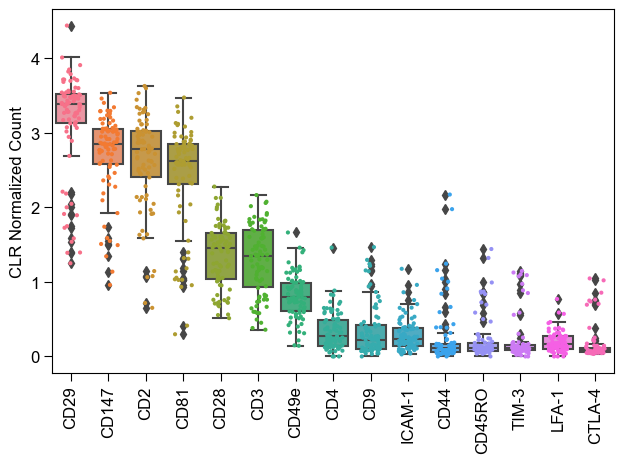

In [28]:
#check rank of protein abundance in NC sample 
# create a dotplot
count_rank = clr_protein_nc.transpose().sum(axis=0).sort_values(ascending=False)
top_ = count_rank.head(16)
ax = sns.boxplot(data=clr_protein_nc.transpose()[top_.index])
ax = sns.stripplot(data=clr_protein_nc.transpose()[top_.index], jitter=0.25, size=3, rasterized=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('CLR Normalized Count')

# Show the plot
plt.tight_layout()
plt.savefig(save_dir+"SI_jurkat_nc_protein.svg",
            bbox_inches='tight', pad_inches=0.5)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


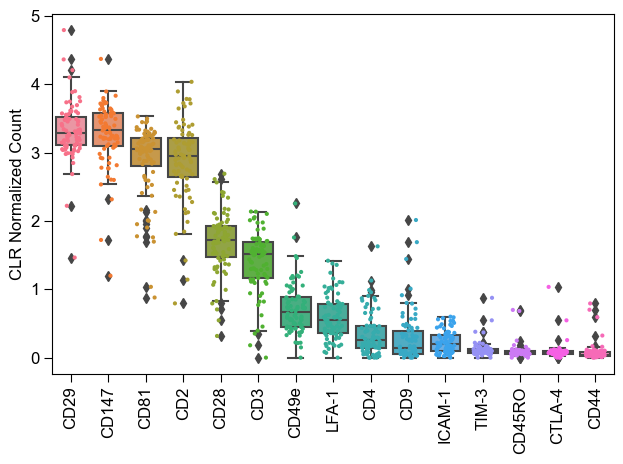

In [27]:
#check rank of protein abundance in NC sample 
# create a dotplot
count_rank = clr_protein_sia.transpose().sum(axis=0).sort_values(ascending=False)
top_ = count_rank.head(16)
ax = sns.boxplot(data=clr_protein_sia.transpose()[top_.index])
ax = sns.stripplot(data=clr_protein_sia.transpose()[top_.index], jitter=0.25, size=3,rasterized=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('CLR Normalized Count')

# Show the plot
plt.tight_layout()
plt.savefig(save_dir+"SI_jurkat_sia_protein.svg",
            bbox_inches='tight', pad_inches=0.5)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


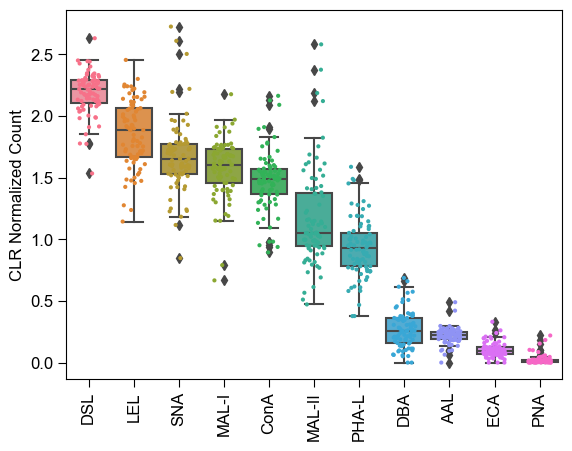

In [15]:
#check rank of protein abundance in NC sample 
# create a dotplot
count_rank = clr_lectin_nc.transpose().sum(axis=0).sort_values(ascending=False)
top_ = count_rank.head(11)
ax = sns.boxplot(data=clr_lectin_nc.transpose()[top_.index])
ax = sns.stripplot(data=clr_lectin_nc.transpose()[top_.index], jitter=0.25, size=3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('CLR Normalized Count')

# Show the plot
plt.show()

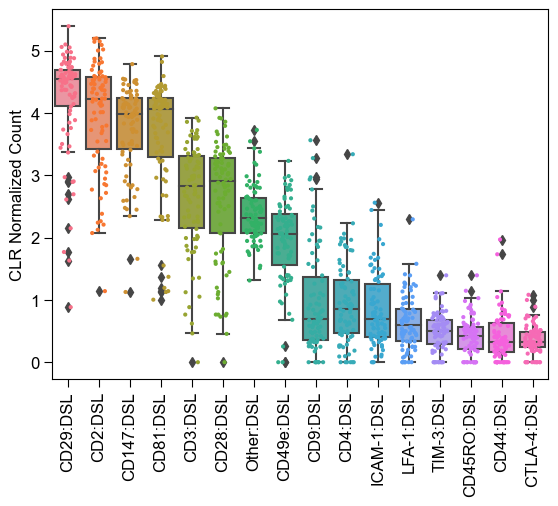

In [58]:
#for certain lectin, check protein-specific glycosylation
#here show the example of DSL
# create a dotplot
count_rank = clr_pla_nc.loc[clr_pla_nc.index.str.contains('DSL'),:].transpose().sum(axis=0).sort_values(ascending=False)
top_ = count_rank.head(16)
ax = sns.boxplot(data=clr_pla_nc.loc[clr_pla_nc.index.str.contains('DSL'),:].transpose()[top_.index])
ax = sns.stripplot(data=clr_pla_nc.loc[clr_pla_nc.index.str.contains('DSL'),:].transpose()[top_.index], jitter=0.25, size=3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('CLR Normalized Count')

# Show the plot
plt.show()

In [18]:
clr_pla_nc.index = clr_pla_nc.index.to_series().str.replace('free_oligo', 'Other', regex=False)
clr_pla_sia.index = clr_pla_sia.index.to_series().str.replace('free_oligo', 'Other', regex=False)

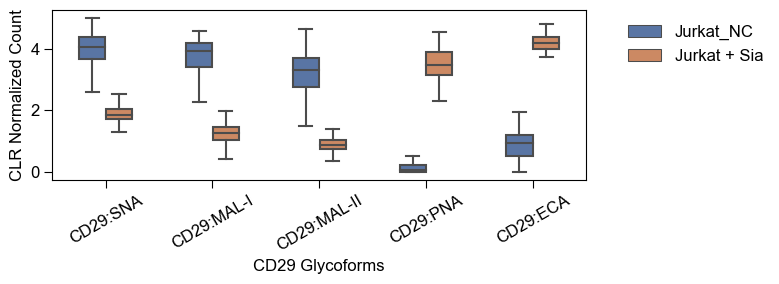

In [13]:
# List of proteins to compare
my_targets = ['CD29:SNA', 'CD29:MAL-I', 'CD29:MAL-II', 'CD29:PNA', 'CD29:ECA']

# Add a 'type' column to differentiate conditions
clr_pla_nc['type'] = 'NC'
clr_pla_sia['type'] = 'Sia'

# Select only the rows corresponding to `my_proteins`
clr_pla_nc_filtered = clr_pla_nc.loc[my_targets, :]
clr_pla_sia_filtered = clr_pla_sia.loc[my_targets, :]

# Add the 'type' column to distinguish conditions
clr_pla_nc_filtered['type'] = 'Jurkat_NC'
clr_pla_sia_filtered['type'] = 'Jurkat + Sia'

# Combine the datasets along rows
combined_data = pd.concat([clr_pla_nc_filtered, clr_pla_sia_filtered], axis=0)

# Reshape the data for plotting
plot_data = combined_data.reset_index().melt(id_vars=['index', 'type'], 
                                             var_name='Cell', 
                                             value_name='Expression')
plot_data.rename(columns={'index': 'Protein'}, inplace=True)

# Create a box plot for single-cell data
plt.figure(figsize=(8, 3))
sns.boxplot(data=plot_data, x='Protein', y='Expression', hue='type', palette='deep', showfliers=False, width=0.5)

# Customize the plot
#plt.title('Comparison of Protein Expression Between NC and Sia Conditions (Single-Cell Data)', fontsize=14)
plt.xlabel('CD29 Glycoforms', fontsize=12)
plt.ylabel('CLR Normalized Count', fontsize=12)
plt.legend(title='', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.xticks(rotation=30, fontsize=12)

# Display the plot
plt.tight_layout()
plt.savefig(save_dir+"Fig3_CD29_glycome.svg",
            bbox_inches='tight', pad_inches=0)
#sns.despine()

In [19]:
#function to show protein-specific glycosylation
def boxplot(df, protein):
    count_rank = df.loc[df.index.str.contains(f'{protein}:'),:].transpose().sum(axis=0).sort_values(ascending=False)
    top_ = count_rank.head(12)
    ax = sns.boxplot(data=df.loc[df.index.str.contains(f'{protein}:'),:].transpose()[top_.index])
    ax = sns.stripplot(data=df.loc[df.index.str.contains(f'{protein}:'),:].transpose()[top_.index], jitter=0.25, size=3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylabel('CLR Normalized Count')
    # Show the plot
    plt.show()

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


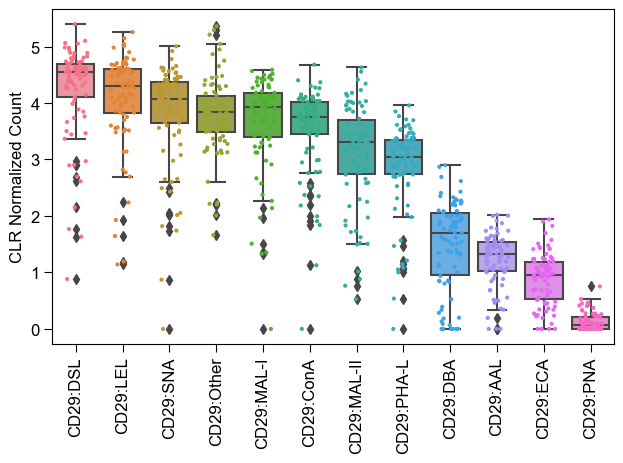

In [29]:
#for certain protein, check protein-specific glycosylation
#here show the example of CD29
# create a dotplot
count_rank = clr_pla_nc.loc[clr_pla_nc.index.str.contains('CD29:'),:].transpose().sum(axis=0).sort_values(ascending=False)
top_ = count_rank.head(12)
ax = sns.boxplot(data=clr_pla_nc.loc[clr_pla_nc.index.str.contains('CD29:'),:].transpose()[top_.index])
ax = sns.stripplot(data=clr_pla_nc.loc[clr_pla_nc.index.str.contains('CD29:'),:].transpose()[top_.index], jitter=0.25, size=3,rasterized=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('CLR Normalized Count')

# Show the plot
plt.tight_layout()
plt.savefig(save_dir+"SI_jurkat_CD29_nc.svg",
            bbox_inches='tight', pad_inches=0.5)

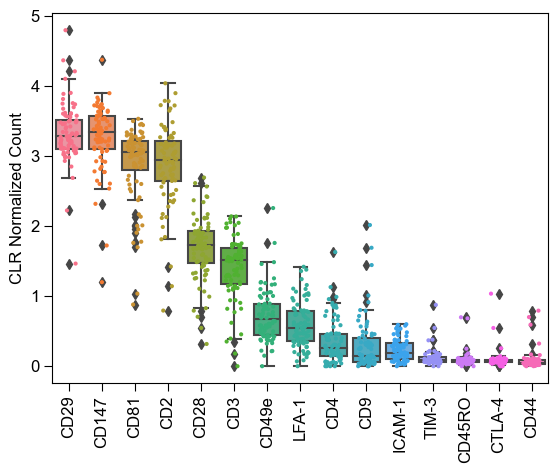

In [44]:
#check rank of protein abundance in sia sample 
# create a dotplot
count_rank = clr_protein_sia.transpose().sum(axis=0).sort_values(ascending=False)
top_ = count_rank.head(16)
ax = sns.boxplot(data=clr_protein_sia.transpose()[top_.index])
ax = sns.stripplot(data=clr_protein_sia.transpose()[top_.index], jitter=0.25, size=3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('CLR Normalized Count')

# Show the plot
plt.show()

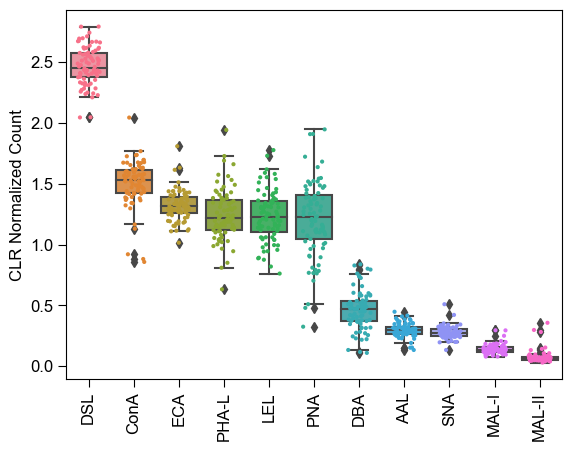

In [59]:
#check rank of glycan abundance in sia sample 
# create a dotplot
count_rank = clr_lectin_sia.transpose().sum(axis=0).sort_values(ascending=False)
top_ = count_rank.head(16)
ax = sns.boxplot(data=clr_lectin_sia.transpose()[top_.index])
ax = sns.stripplot(data=clr_lectin_sia.transpose()[top_.index], jitter=0.25, size=3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('CLR Normalized Count')

# Show the plot
plt.show()

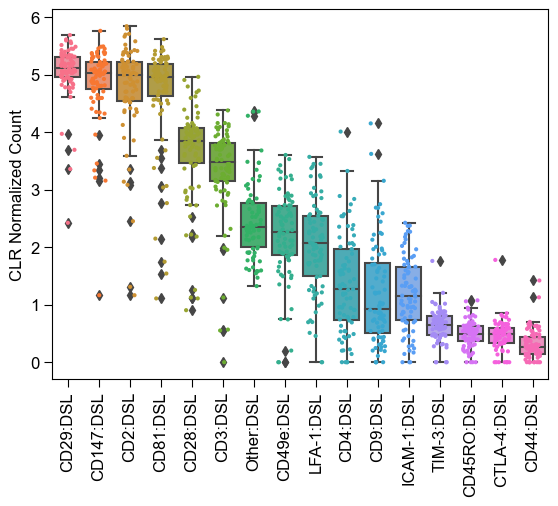

In [60]:
#for certain lectin, check protein-specific glycosylation
#here show the example of DSL
# create a dotplot
count_rank = clr_pla_sia.loc[clr_pla_sia.index.str.contains('DSL'),:].transpose().sum(axis=0).sort_values(ascending=False)
top_ = count_rank.head(16)
ax = sns.boxplot(data=clr_pla_sia.loc[clr_pla_sia.index.str.contains('DSL'),:].transpose()[top_.index])
ax = sns.stripplot(data=clr_pla_sia.loc[clr_pla_sia.index.str.contains('DSL'),:].transpose()[top_.index], jitter=0.25, size=3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('CLR Normalized Count')

# Show the plot
plt.show()

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


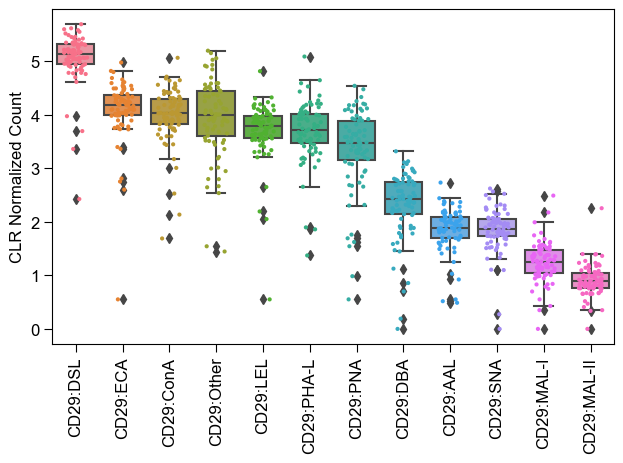

In [26]:
#for certain protein, check protein-specific glycosylation
#here show the example of CD29
# create a dotplot
count_rank = clr_pla_sia.loc[clr_pla_sia.index.str.contains('CD29:'),:].transpose().sum(axis=0).sort_values(ascending=False)
top_ = count_rank.head(12)
#plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=clr_pla_sia.loc[clr_pla_sia.index.str.contains('CD29:'),:].transpose()[top_.index])
ax = sns.stripplot(data=clr_pla_sia.loc[clr_pla_sia.index.str.contains('CD29:'),:].transpose()[top_.index], jitter=0.25, size=3,rasterized=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('CLR Normalized Count')

# Show the plot
plt.tight_layout()
plt.savefig(save_dir+"SI_jurkat_sia_cd29.svg",
            bbox_inches='tight', pad_inches=0.5)

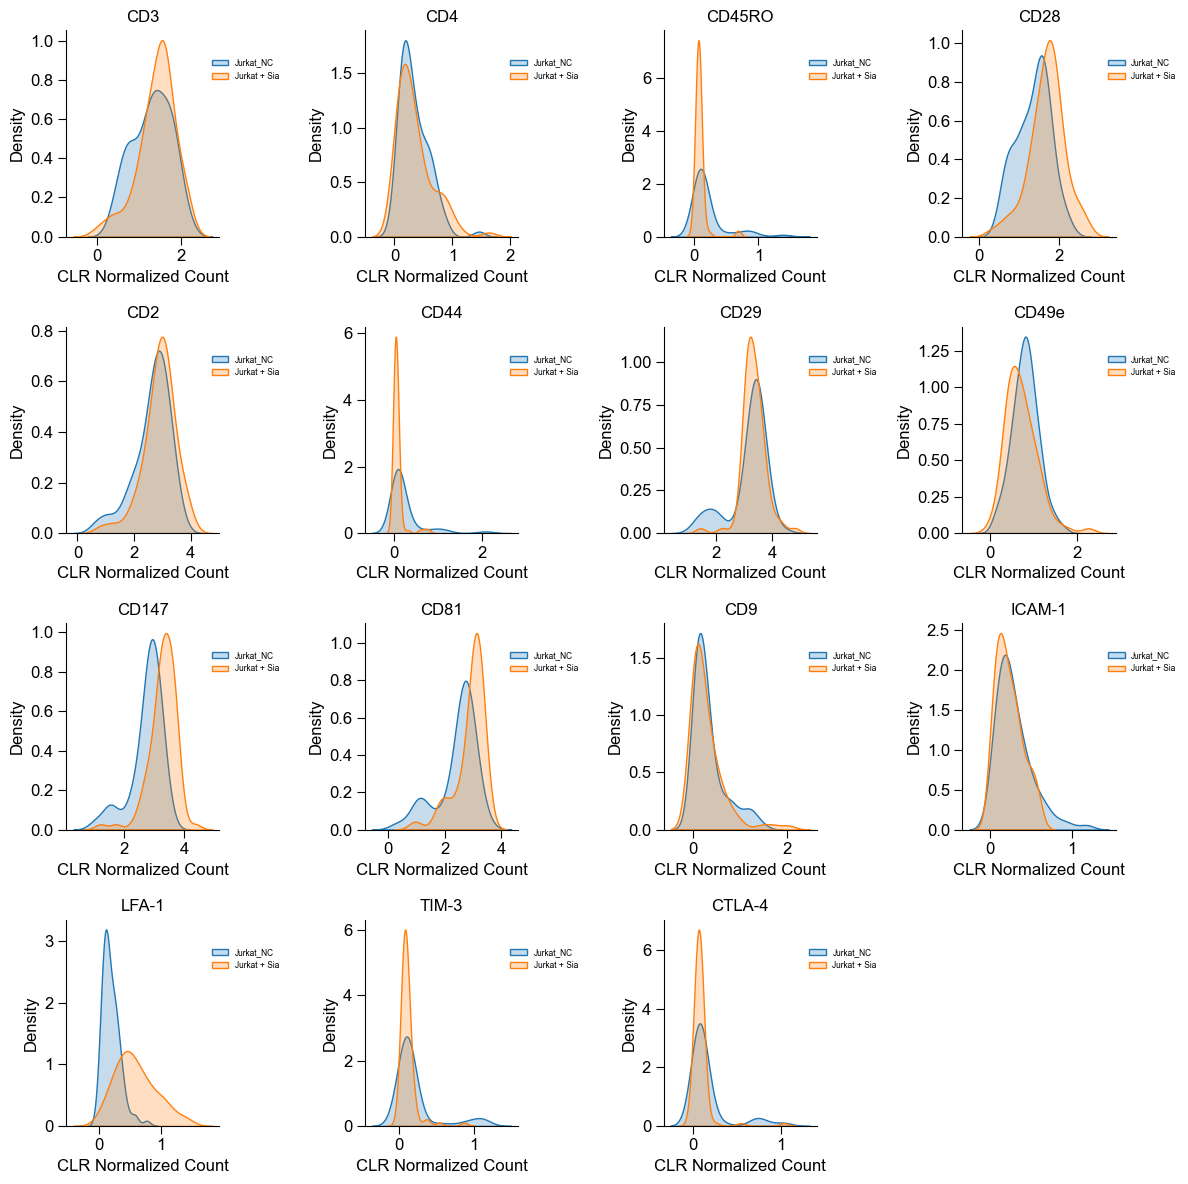

In [14]:
#kde plot for protein
temp1 = pd.DataFrame(0, index=clr_protein_nc.columns, columns=clr_protein_nc.index)
for i in temp1.columns:
    temp1.loc[:,i] = clr_protein_nc.loc[i,:]
temp1.loc[:,"type"] = "Jurkat_NC"

temp2 = pd.DataFrame(0, index=clr_protein_sia.columns, columns=clr_protein_sia.index)
for i in temp2.columns:
    temp2.loc[:,i] = clr_protein_sia.loc[i,:]
temp2.loc[:,"type"] = "Jurkat + Sia"

# Combine data
temp = pd.concat((temp1, temp2), axis=0) 


# Creating KDE plot with stripplot overlay
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))  
np.random.seed(1)

for counter, val in enumerate(my_protein):
    row = counter // 4
    col = counter % 4
    sns.kdeplot(x=val, data=temp[temp['type']=='Jurkat_NC'], fill=True, label='Jurkat_NC', ax=ax[row,col])
    sns.kdeplot(x=val, data=temp[temp['type']=='Jurkat + Sia'], fill=True, label='Jurkat + Sia', ax=ax[row,col])
    ax[row, col].set_title(val)
    ax[row, col].set_xlabel('CLR Normalized Count')
    ax[row, col].legend(loc='upper left', bbox_to_anchor=(0.9,0.9),frameon=False, prop={'size': 6})
# Hide empty subplots
ax[-1,-1].axis("off")

fig.tight_layout(w_pad=1.3, h_pad=1.3)  # Adjust layout spacing
sns.despine(fig=fig)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/si

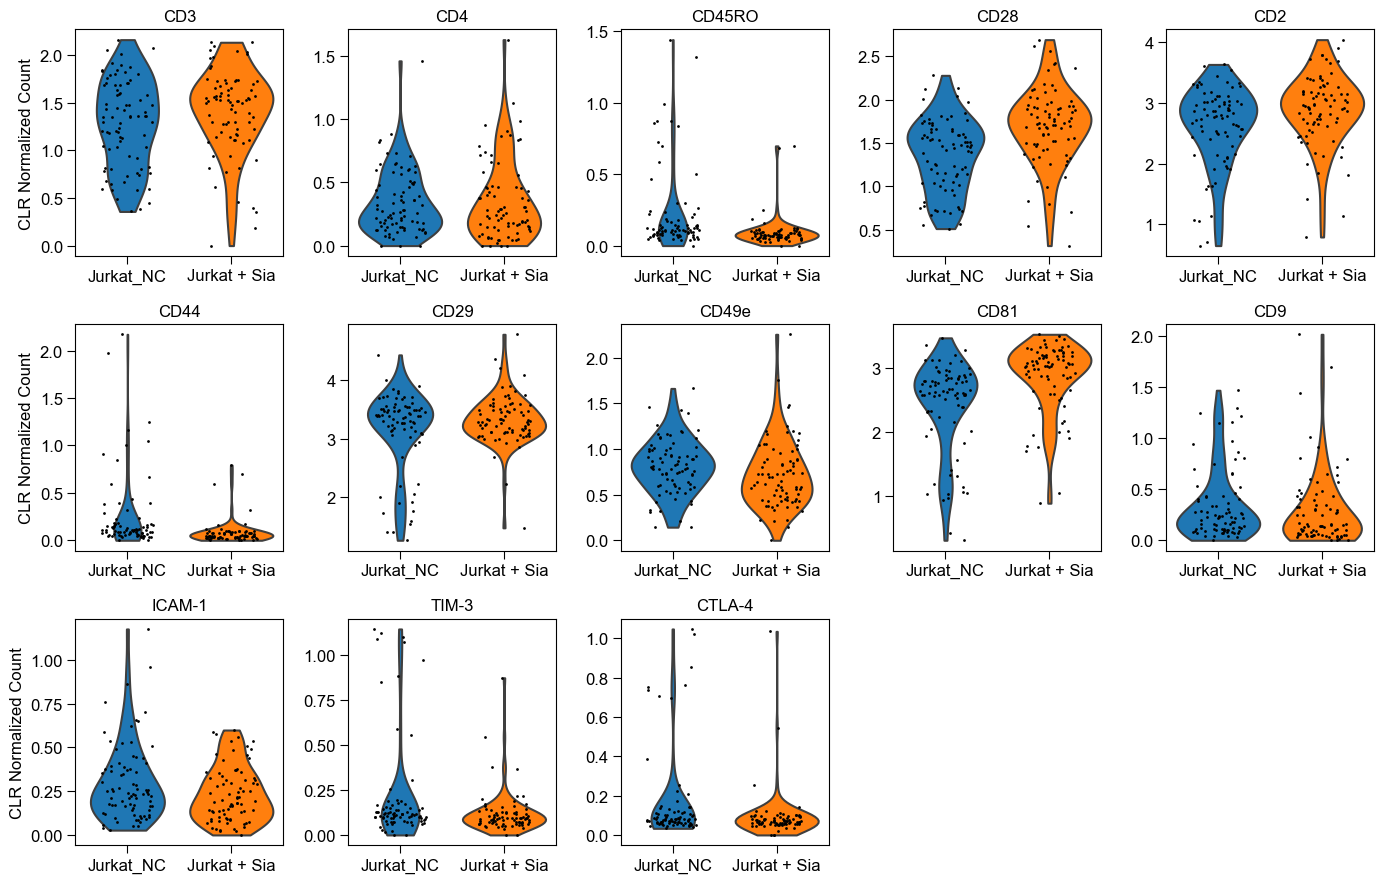

In [32]:
# Combine CLR-normalized data
temp1 = clr_protein_nc.T.copy()
temp1["type"] = "Jurkat_NC"
temp2 = clr_protein_sia.T.copy()
temp2["type"] = "Jurkat + Sia"
temp = pd.concat([temp1, temp2])

# Exclude unwanted proteins
excluded = ["CD147", "LFA-1"]
plot_proteins = [p for p in my_protein if p not in excluded]

# Define grid layout
nrows, ncols = 3, 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 9))
ax = ax.flatten()

# Plot violin plots
for i, val in enumerate(plot_proteins[:len(ax)]):
    sns.violinplot(y=val, x="type", data=temp, ax=ax[i],
                   cut=0, saturation=1, inner=None)
    sns.stripplot(y=val, x="type", data=temp, ax=ax[i],
                  jitter=0.25, color='k', size=2)
    ax[i].set_title(val)
    ax[i].set_xlabel("")
    if i % ncols == 0:
        ax[i].set_ylabel("CLR Normalized Count")
    else:
        ax[i].set_ylabel("")

# Turn off unused axes
for j in range(len(plot_proteins), len(ax)):
    ax[j].axis('off')

# Save figure
plt.tight_layout(w_pad=1.2, h_pad=1.2)
plt.savefig(save_dir + "SI_jurkat_sia_protein_comparison.svg", bbox_inches='tight', pad_inches=0)


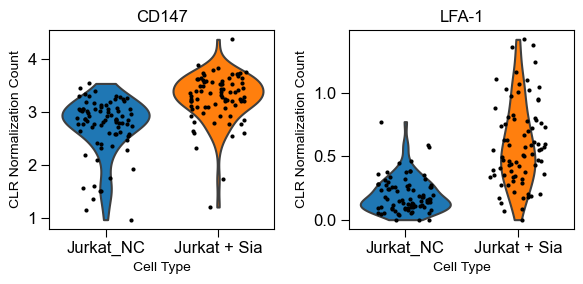

In [16]:
# Protein list
my_protein_2 = ['CD147', 'LFA-1']

# Adjust layout for 2 proteins
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))  # 1 row, 2 columns
np.random.seed(1)

for counter, val in enumerate(my_protein_2):  # Iterate over the protein list
    sns.violinplot(
        y=val, x="type", data=temp, ax=ax[counter],
        cut=0, saturation=1, inner=None, #palette="Set2"
    )
    sns.stripplot(
        y=val, x="type", data=temp, ax=ax[counter],
        jitter=0.25, color='k', size=3
    )
    ax[counter].set_title(val, fontsize=12)
    ax[counter].set_xlabel("Cell Type", fontsize=10)
    ax[counter].set_ylabel("CLR Normalization Count", fontsize=10)

# Adjust layout and aesthetics
fig.tight_layout(w_pad=1.3, h_pad=1.3)
fig.savefig(save_dir+"Fig3_CD147_LFA1.svg",
            bbox_inches='tight', pad_inches=0)
#sns.despine(fig=fig)  # Remove spines for cleaner plots

In [26]:
#t-test
from scipy.stats import ttest_ind

# Initialize a dictionary to store the p-values
p_values = {}

# Loop through each protein in the list
for protein in my_protein:
    # Extract data for the two groups
    group1 = temp[temp["type"] == "Jurkat_NC"][protein]
    group2 = temp[temp["type"] == "Jurkat + Sia"][protein]
    
    # Perform an independent t-test (assumes data is normally distributed)
    t_stat, p_val = ttest_ind(group1, group2, alternative='less')
    
    # Store the p-value
    p_values[protein] = p_val

# Convert the p-values dictionary into a DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])

# Add a significance flag (e.g., p < 0.05)
p_values_df['significant'] = p_values_df['p_value'] < 0.001

In [28]:
#Mann-Whitney U test
from scipy.stats import mannwhitneyu

# Initialize a dictionary to store the p-values
p_values = {}

# Replace t-test with Mann-Whitney U test
for protein in my_protein:
    group1 = temp[temp["type"] == "Jurkat_NC"][protein]
    group2 = temp[temp["type"] == "Jurkat + Sia"][protein]
    
    u_stat, p_val = mannwhitneyu(group1, group2, alternative='less')
    p_values[protein] = p_val

    # Convert the p-values dictionary into a DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])

# Add a significance flag (e.g., p < 0.05)
p_values_df['significant'] = p_values_df['p_value'] < 0.001

In [29]:
p_values_df

,p_value,significant
CD3,4.647619e-02,False
CD4,6.798730e-01,False
CD45RO,9.999999e-01,False
CD28,6.096476e-07,True
CD2,4.735390e-03,False
CD44,1.000000e+00,False
CD29,6.075830e-01,False
CD49e,9.922478e-01,False
CD147,9.158791e-13,True
CD81,1.303070e-08,True


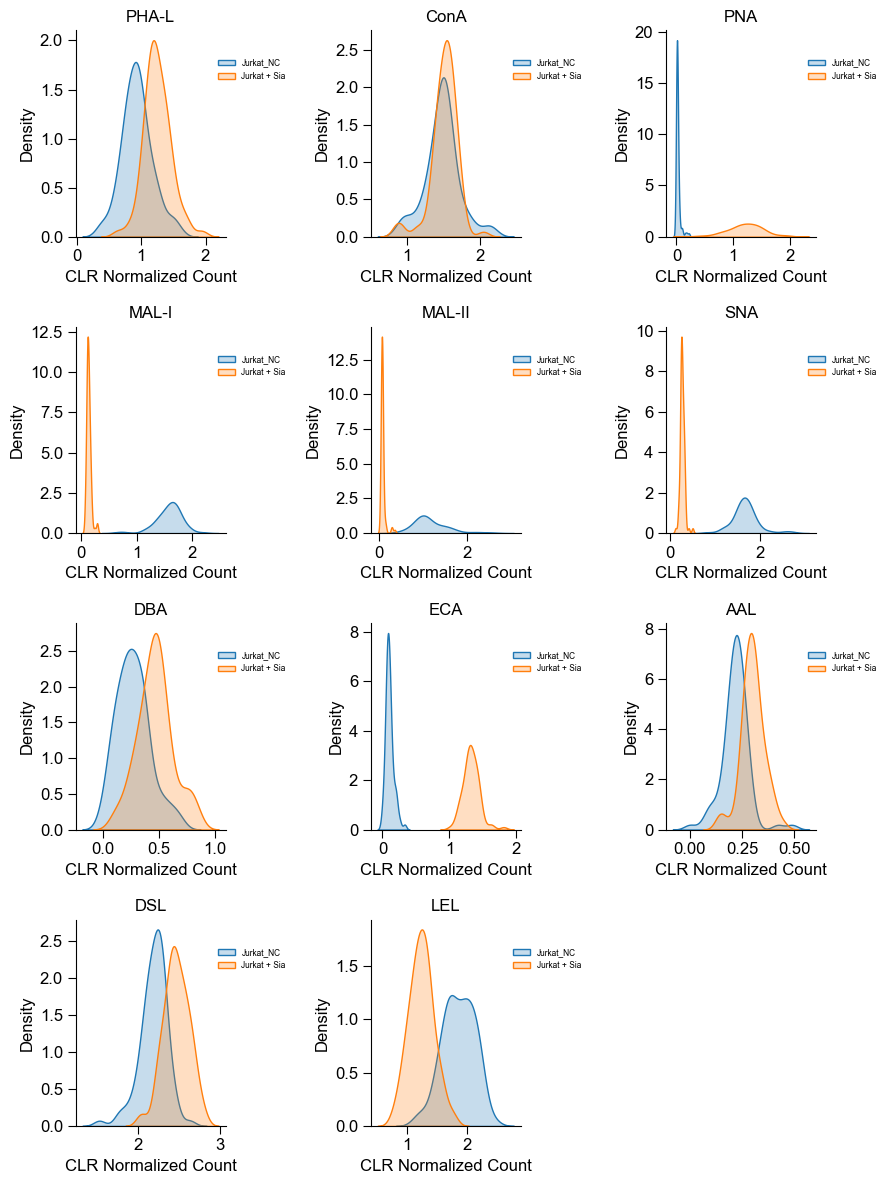

In [17]:
#kde plot for glycan
temp1 = pd.DataFrame(0, index=clr_lectin_nc.columns, columns=clr_lectin_nc.index)
for i in temp1.columns:
    temp1.loc[:,i] = clr_lectin_nc.loc[i,:]

temp1.loc[:,"type"] = "Jurkat_NC"
temp2 = pd.DataFrame(0, index=clr_lectin_sia.columns, columns=clr_lectin_sia.index)
for i in temp2.columns:
    temp2.loc[:,i] = clr_lectin_sia.loc[i,:]
temp2.loc[:,"type"] = "Jurkat + Sia"
temp = pd.concat((temp1, temp2), axis=0)

# Combine data
temp = pd.concat((temp1, temp2), axis=0)


fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(9,12))
np.random.seed(1)
for counter, val in enumerate(my_lectin):
    row = counter // 3
    col = counter % 3
    sns.kdeplot(x=val, data=temp[temp['type']=='Jurkat_NC'], fill=True, label='Jurkat_NC', ax=ax[row,col])
    sns.kdeplot(x=val, data=temp[temp['type']=='Jurkat + Sia'], fill=True, label='Jurkat + Sia', ax=ax[row,col])
    ax[row, col].set_title(val)
    ax[row, col].set_xlabel('CLR Normalized Count')
    ax[row, col].legend(loc='upper left', bbox_to_anchor=(0.9,0.9),frameon=False, prop={'size': 6})
# Hide empty subplots
ax[-1, -1].axis('off')

fig.tight_layout(w_pad=1.3, h_pad=1.3)  # Adjust layout spacing
sns.despine(fig=fig)

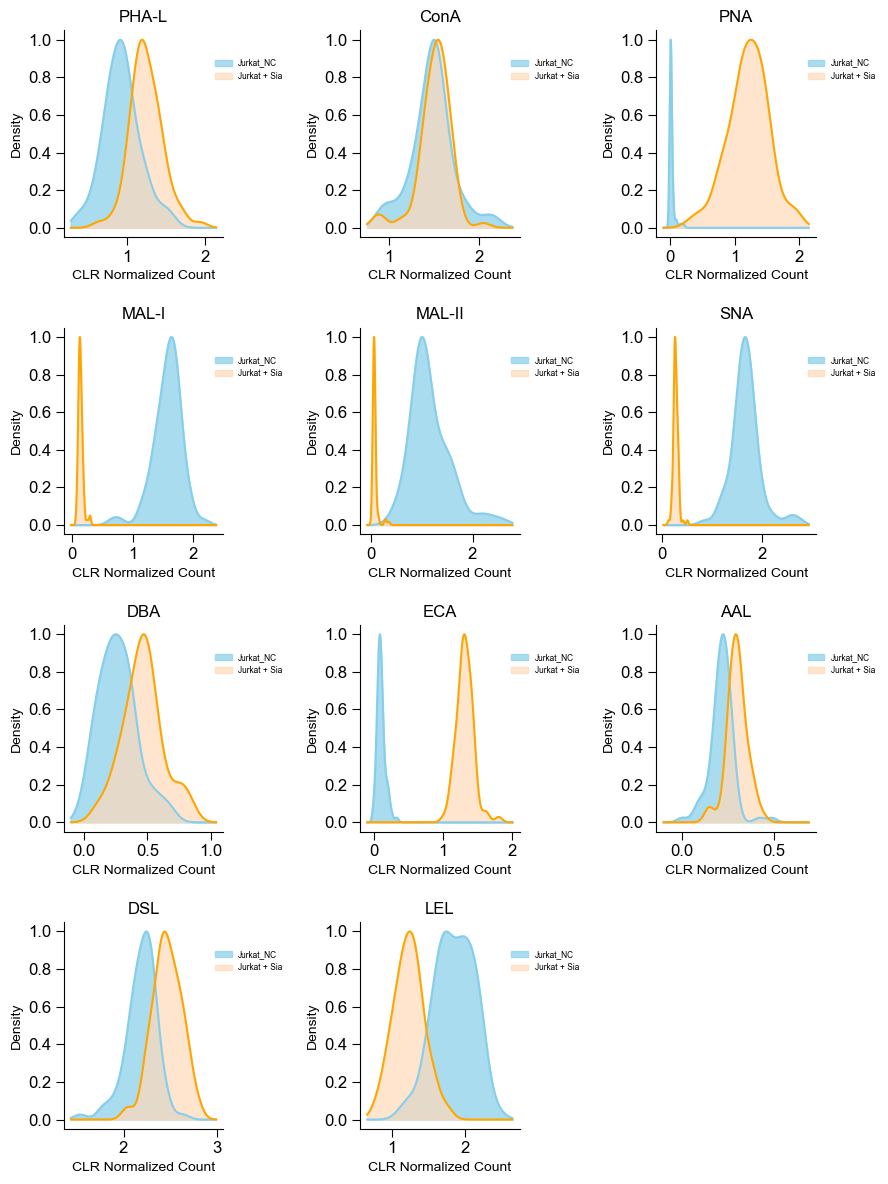

In [18]:
from scipy.stats import gaussian_kde

# Create KDE plots
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(9, 12))
np.random.seed(1)

for counter, val in enumerate(my_lectin):
    row = counter // 3
    col = counter % 3
    
    # Extract data for KDE computation
    data_nc = temp[temp['type'] == 'Jurkat_NC'][val].dropna()
    data_sia = temp[temp['type'] == 'Jurkat + Sia'][val].dropna()
    
    # Compute KDE
    x_vals = np.linspace(min(data_nc.min()-0.1, data_sia.min()-0.1), 
                         max(data_nc.max()+0.2, data_sia.max()+0.2), 1000)
    
    kde_nc = gaussian_kde(data_nc)(x_vals)
    kde_sia = gaussian_kde(data_sia)(x_vals)
    
    # Normalize to max density
    kde_nc /= kde_nc.max()
    kde_sia /= kde_sia.max()
    
    # Plot normalized KDE with fill and edge
    ax[row, col].fill_between(x_vals, kde_nc, color='skyblue', alpha=0.7, label='Jurkat_NC')
    ax[row, col].fill_between(x_vals, kde_sia, color='peachpuff', alpha=0.7, label='Jurkat + Sia')
    
    # Add line edges
    ax[row, col].plot(x_vals, kde_nc, color='skyblue', lw=1.5)
    ax[row, col].plot(x_vals, kde_sia, color='orange', lw=1.5)
    
    # Titles and labels
    ax[row, col].set_title(val, fontsize=12)
    ax[row, col].set_xlabel('CLR Normalized Count', fontsize=10)
    ax[row, col].set_ylabel('Density', fontsize=10)
    ax[row, col].legend(loc='upper left', bbox_to_anchor=(0.9,0.9),frameon=False, prop={'size': 6})

# Hide empty subplots
for i in range(len(my_lectin), ax.size):
    ax.flatten()[i].axis('off')

fig.tight_layout(w_pad=1.5, h_pad=1.5)  # Adjust layout spacing
sns.despine(fig=fig)

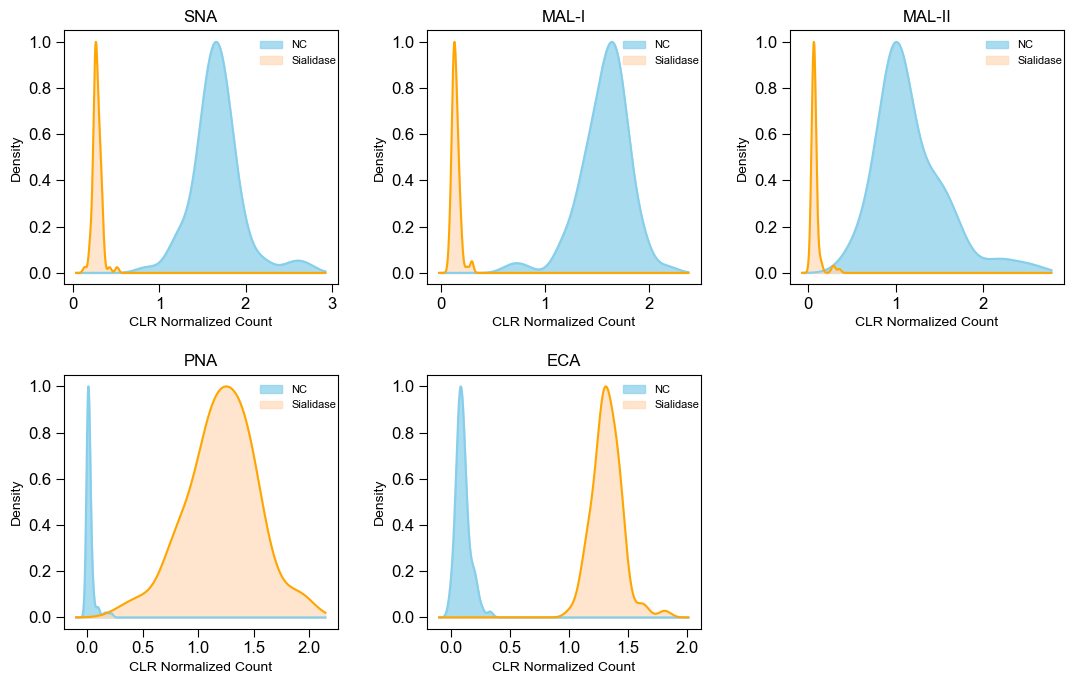

In [19]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# List of lectins for the plots
my_lectin_sia = ['SNA', 'MAL-I', 'MAL-II', 'PNA', 'ECA']

# Create KDE plots with a 2x3 grid
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(11, 7))
np.random.seed(1)

for counter, val in enumerate(my_lectin_sia):
    row = counter // 3  # Determine the row index
    col = counter % 3  # Determine the column index
    
    # Extract data for KDE computation
    data_nc = temp[temp['type'] == 'Jurkat_NC'][val].dropna()
    data_sia = temp[temp['type'] == 'Jurkat + Sia'][val].dropna()
    
    # Compute KDE
    x_vals = np.linspace(
        min(data_nc.min() - 0.1, data_sia.min() - 0.1), 
        max(data_nc.max() + 0.2, data_sia.max() + 0.2), 
        1000
    )
    kde_nc = gaussian_kde(data_nc)(x_vals)
    kde_sia = gaussian_kde(data_sia)(x_vals)
    
    # Normalize to max density
    kde_nc /= kde_nc.max()
    kde_sia /= kde_sia.max()
    
    # Plot normalized KDE with fill and edge
    ax[row, col].fill_between(x_vals, kde_nc, color='skyblue', alpha=0.7, label='NC')
    ax[row, col].fill_between(x_vals, kde_sia, color='peachpuff', alpha=0.7, label='Sialidase')
    ax[row, col].plot(x_vals, kde_nc, color='skyblue', lw=1.5)
    ax[row, col].plot(x_vals, kde_sia, color='orange', lw=1.5)
    
    # Titles and labels
    ax[row, col].set_title(val, fontsize=12)
    ax[row, col].set_xlabel('CLR Normalized Count', fontsize=10)
    ax[row, col].set_ylabel('Density', fontsize=10)
    ax[row, col].legend(loc='upper left', bbox_to_anchor=(0.68, 1), frameon=False, prop={'size': 8})

# Hide unused subplots
for i in range(len(my_lectin_sia), ax.size):
    ax.flatten()[i].axis('off')

# Adjust layout
fig.tight_layout(w_pad=1.5, h_pad=1.5)
fig.savefig(save_dir+"Fig3_lectin_histogram.svg",
            bbox_inches='tight', pad_inches=0)
#sns.despine(fig=fig)  # Remove unnecessary spines

(array([32., 17., 24., 13.,  5.,  1.,  1.,  0.,  0.,  1.]),
 array([3.00000e+01, 6.13150e+03, 1.22330e+04, 1.83345e+04, 2.44360e+04,
        3.05375e+04, 3.66390e+04, 4.27405e+04, 4.88420e+04, 5.49435e+04,
        6.10450e+04]),
 <BarContainer object of 10 artists>)

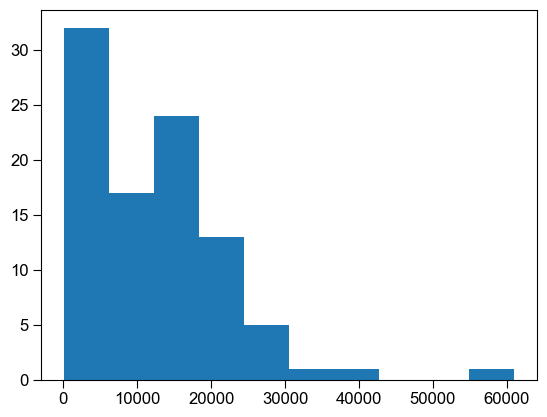

In [6]:
plt.hist(jurkat_nc.sum(axis=0))

(array([22., 13., 16., 15., 14.,  6.,  6.,  0.,  1.,  1.]),
 array([4.00000e+00, 7.96730e+03, 1.59306e+04, 2.38939e+04, 3.18572e+04,
        3.98205e+04, 4.77838e+04, 5.57471e+04, 6.37104e+04, 7.16737e+04,
        7.96370e+04]),
 <BarContainer object of 10 artists>)

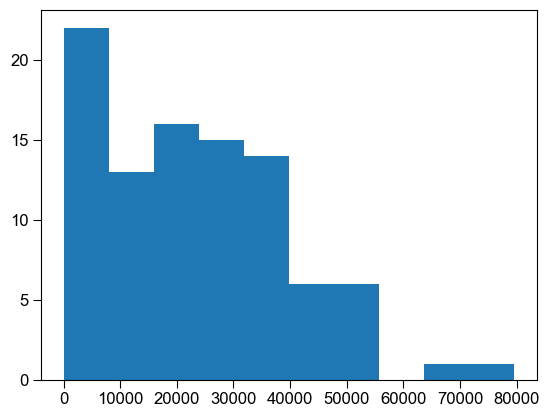

In [7]:
plt.hist(jurkat_sia.sum(axis=0))